In [70]:
library(openxlsx)
library(tidyverse)
library(reshape)
library(mgsub) # mapping

library(ggplot2)
library(ggpubr)
library(RColorBrewer)
library(corrplot)
library(corrr)

library(psych)
#optimal number of components
library(nFactors)
#library(pheatmap)

In [71]:
# Organize relationship score
regions = c(
    # English
    'USA','UK','Australia','South Africa',
    # Germany
    'Germany',
    # Japanese
    'Japan',
    # Hebrew
    'Israel',
    # Chinese
    'CHN','HK(region)',

    # French
    'France',
    # Spanish
    'Spain','Mexico','Chile',
    # Portuguese
    'Portugal','Brazil',
    # Russian
    'Russia',
    # Arabic
    'Egypt','Qatar',
    'India')

In [2]:
file_path = 'output_data/cleaning_results/'
raw_data_list = list()
for (region in dir(file_path)){
    file = paste(file_path,region,sep='')
    file = paste(paste(file,'/',sep=''),region,sep='')
    file = paste(file,'_dim_rel.csv',sep='')
    raw_df = read.csv(file,row.names=1)
    raw_df = data.frame(t(raw_df))
    
    region = gsub('HK','HK(region)',region) 
    region = gsub('South_africa','South Africa',region)
    
    # The dimension should be reversed due to the questionnair set
    if (region %in% c('Chile','Mexico','Spain')){
        raw_df['Goods.Exchange'] = 100-raw_df['Goods.Exchange']}
    if (region %in% c('Israel')){
        raw_df['Socioemotional'] = 100-raw_df['Socioemotional']
        raw_df['Synchronicity'] = 100-raw_df['Synchronicity']}
    if (region %in% c('Brazil','Portugal','Russia')){
        raw_df['Morality'] = 100-raw_df['Morality']}
    if (region %in% c('France')){
        raw_df['Formality.and.Regulation'] = 100-raw_df['Formality.and.Regulation']
        raw_df['Expected.Reciprocity'] = 100-raw_df['Expected.Reciprocity']
        raw_df['Information.Exchange'] = 100-raw_df['Information.Exchange']
        raw_df['Money.Exchange'] = 100-raw_df['Money.Exchange']
        raw_df['Mating'] = 100-raw_df['Mating']
        raw_df['Importance.for.society'] = 100-raw_df['Importance.for.society']
        raw_df['Importance.for.individuals'] = 100-raw_df['Importance.for.individuals']
        raw_df['Occupational'] = 100-raw_df['Occupational']}

    raw_data_list[[region]] = raw_df}

# Averaged results

In [74]:
world_averaged = data.frame(matrix(0,nrow=159,ncol=33))
for (region in regions){
    region_df = raw_data_list[[region]]
    world_averaged = world_averaged + region_df
}

world_averaged = world_averaged/19
relationships = read.csv('input_data/RelDim_labels/159relationships_fix_label.csv',
                        row.names=1)
relationships = relationships$'X0'
dimensions = read.csv('input_data/RelDim_labels/dimensions_33d.csv',row.names=1)
dimensions = dimensions$'X0'

colnames(world_averaged) = dimensions
rownames(world_averaged) = relationships

write.csv(world_averaged,'input_data/Nations/Total/output_data/Total_var_33v.csv')
write.csv(scale(world_averaged),'input_data/Nations/Total/output_data/Total_scale_var_33v.csv')

# Optimal dimension

In [77]:
plotnScree <-
function (nScree,
          elbow = 3,
          legend = TRUE,
          ylab   = "Eigenvalues",
          xlab   = "Components",
          main   = "Non Graphical Solutions to Scree Test")
          {
   if (!inherits(nScree, "nScree"))  stop("Method is only for nScree objects")
   #if (!exists("legend", mode="logical") ) legend <- TRUE                                   # To develop
   #if (!exists("ylab"))                    ylab <- "Eigenvalues"                            # To develop
   #if (!exists("xlab"))                    xlab <- "Components"                             # To develop
   #if (!exists("main"))                    main <- "Non Graphical Solutions to Scree Test"  # To develop
   if (nScree$Model == "components") nkaiser = "Eigenvalues (>mean  = " else nkaiser = "Eigenvalues (>0 = "
   if (nScree$Model == "factors")  xlab   = "Factors"
   # panel
   par(col   = 1, pch = 1, cex=4)     # Color and symbol for usual scree
   par(mfrow = c(1,1),lwd=2, cex=4)
   eig        <- nScree$Analysis$Eigenvalues
   k          <- 1:length(eig)
   #plotuScree(x=eig, ...)                                                                   # To develop
   plotuScree(x=eig, main=main, xlab=xlab, ylab=ylab,col=2)
   nk         <- length(eig)
   noc        <- nScree$Components$noc
   vp.p       <- lm(eig[c(noc+1,nk)] ~ k[c(noc+1,nk)])
   x          <- sum(c(1,1) * coef(vp.p))
   y          <- sum(c(1,nk)* coef(vp.p))
   par(col = 10, cex=1.8)            # Color for optimal coordinates
   lines(k[c(1,nk)],c(x,y),lwd=1.8)
   par(col = 11,pch=2, cex=1.5)            # Color and symbol for parallel analysis
   lines(1:nk, nScree$Analysis$Par.Analysis, type = "b",lwd=1.8)
   if (legend == TRUE) {
     leg.txt  <- c(paste("Parallel Analysis (n = ",nScree$Components$nparallel,")"),
                 c(paste("Kaiser-Guttman rule (n = ",nScree$Components$nkaiser,")")),
                 c(paste("Cattell’s scree test (n = ",elbow,")")),
                 c(paste("Optimal Coordinates (n = ",nScree$Components$noc,")")) )
     legend("topright",
            legend   = leg.txt,
            pch      = c('△','_','○','_'),
            text.col = c(3,4,1,2), 
            col = c(3,4,1,2),
            cex = 1)
     }
   naf        <-   nScree$Components$naf
   text(x = noc ,    y = eig[noc],     label = " (OC)", cex = 1.2, adj = c(0,0), col = 2)
#    text(x = naf + 1, y = eig[naf + 1], label = " (AF)", cex = .70, adj = c(0,0), col = 4)
   }

In [78]:
dim_rel_scaled = scale(world_averaged)

# Parallel analysis, Optimal Coordinates, and  Cattell's Scree Test
ev <- eigen(cor(dim_rel_scaled)) # get eigenvalues
ap <- parallel(subject=nrow(dim_rel_scaled),var=ncol(dim_rel_scaled),model="components",rep=5000,cent=.05) 
nS <- nScree(x=ev$values, model = "components",aparallel=ap$eigen$qevpea) # "qevpea" indicate 95 centile given cent=.05 
nS$Analysis$Cumu[1:5]

[1] 0.4468336 0.6682188 0.7547065 0.8145523 0.8669602

png 
  2

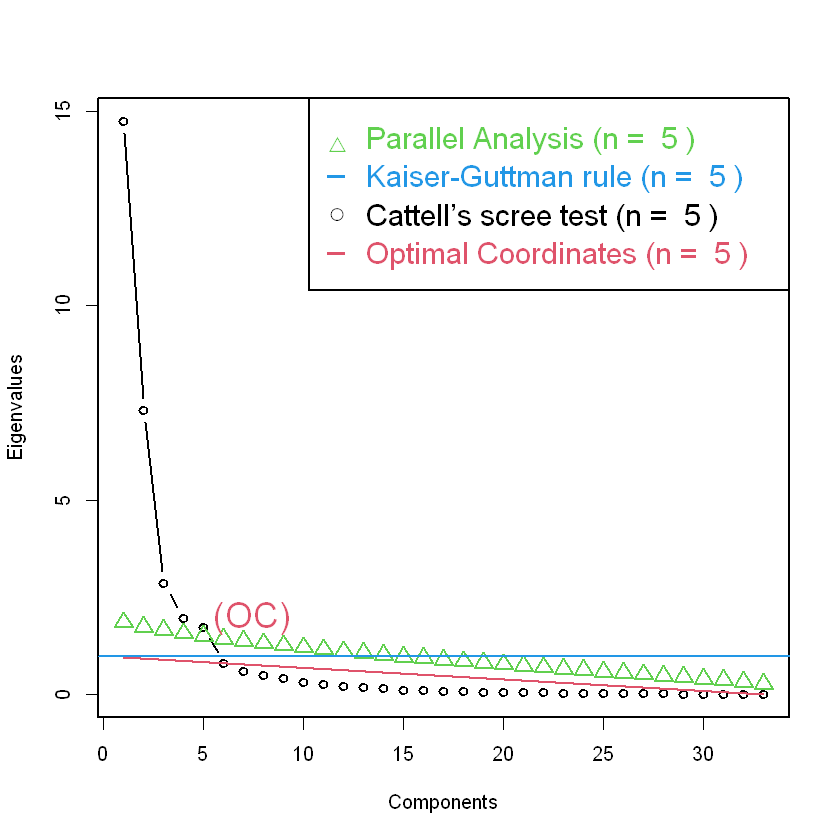

In [79]:
plotnScree(nS, elbow = 5,legend=TRUE, main = NULL)
abline(h = 1, col=4, lty=1,lwd =1.8) # Kaiser-Guttman Rule

png("../output_graph/world_averaged/optimal_components.png",
     family = 'sans',units='in',width=8,height=8,res=300)
plotnScree(nS,elbow = 5, legend=TRUE, main = NULL)
abline(h = 1, col=4, lty=1,lwd =1.8) # Kaiser-Guttman Rule
dev.off()

# Plot loadings

In [76]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]
scores_none = dim_rel.pca$x[,1:ncomp] 

rawLoadings = loadings_none %*% diag(dim_rel.pca$sdev,ncomp,ncomp)
loadings_var = varimax(rawLoadings)$loadings
scores_var = scale(scores_none) %*% varimax(rawLoadings)$rotmat

write.csv(loadings_var,'input_data/Nations/Total/pca_results/Total_loadings_var_5c_33d.csv')
scores_var = as.data.frame(scores_var)
write.csv(scores_var,'input_data/Nations/Total/pca_results/Total_scores_var_5c_33d.csv')

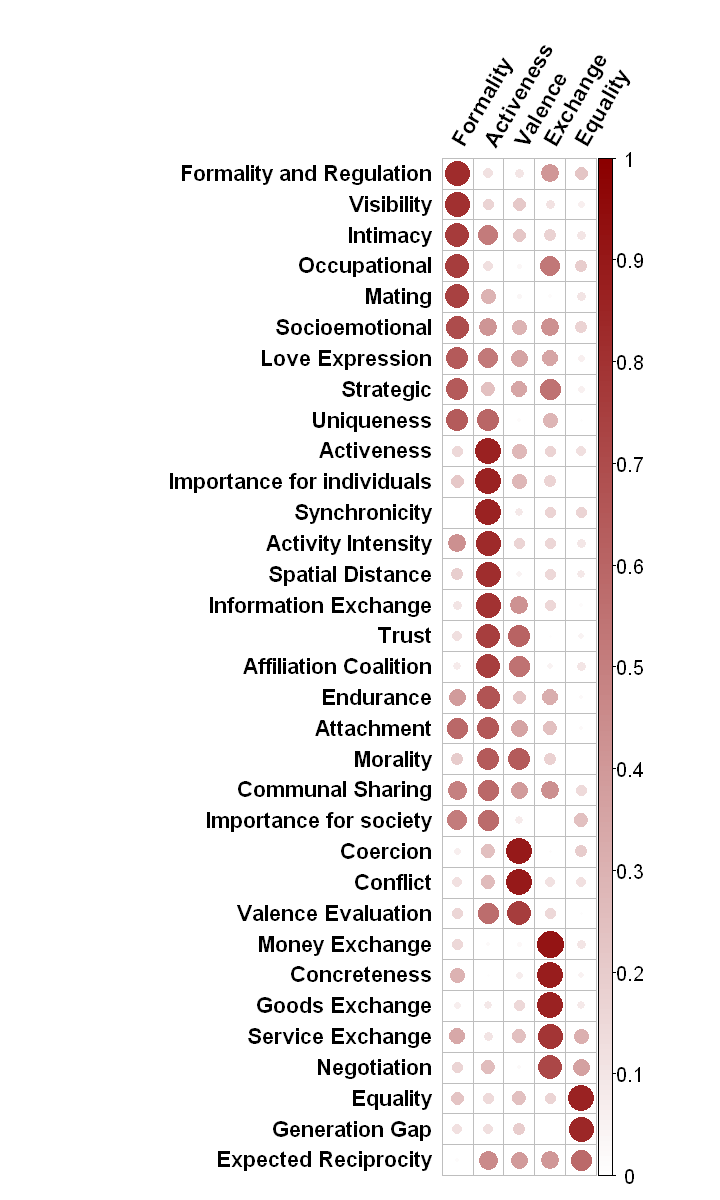

In [80]:
loadings_var_reorder = as.data.frame(loadings_var[,1:5])
colnames(loadings_var_reorder) = c('Activeness','Exchange','Formality','Equality','Valence')
loadings_var_reorder = abs(loadings_var_reorder)
loadings_var_reorder = loadings_var_reorder[,
                        c('Formality','Activeness','Valence','Exchange','Equality')]

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(Formality))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(Activeness))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(Valence))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(Exchange))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(Equality))
rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(abs(loadings_var_reorder)),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(0,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(c("white","darkred"))(length(my.breaks)))

In [81]:
png("../output_graph/world_averaged/loadings.png", bg="transparent",
    family = 'sans',units='in',width=6,height=10,res=300)
pca_5c_33d_loadings_total = read.csv('input_data/Nations/Total/pca_results/Total_loadings_var_5c_33d.csv',row.names=1)
loadings_var = pca_5c_33d_loadings_total
loadings_var_reorder = as.data.frame(loadings_var[,1:5])
colnames(loadings_var_reorder) = c('Activeness','Exchange','Formality','Equality','Valence')
loadings_var_reorder = abs(loadings_var_reorder)
loadings_var_reorder = loadings_var_reorder[,
                        c('Formality','Activeness','Valence','Exchange','Equality')]

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(Formality))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(Activeness))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(Valence))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(Exchange))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(Equality))
rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(abs(loadings_var_reorder)),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(0,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(c("white","darkred"))(length(my.breaks)))
dev.off()

png 
  2